# Content-based Filtering

**By Li-Yen Hsu (11/17/2017)**
<br><br>
The goal of this project is to predict the ratings that would be given by each consumer for the restaurants he/she has not rated. A list of restaurants with the highest predicted ratings can then be recommended to each consumer. Because the restaurant ratings are numerical, predicting their values can be treated as a regression problem. Using classification techniques is also reasonable since the ratings are 0, 1 or 2 in this dataset. However, a multi-class classification will likely predict too many ties and therefore prevent us from generating a top-n list of recommendations for a consumer. Rather than predicting the exact values of ratings that a consumer would give to certain restaurants, what is more important for a recommender system is predicting the ranking of these restaurants for the consumer. Thus, I will attempt to predict continuous values in this notebook.
<br><br>
I will use matrix factorization-based algorithms for rating prediction. The fundamental concepts are that each item is characterized by a vector of features; each consumer preference is described by a vector of weights which has the same dimension as the item features; and the predicted rating of a item-consumer pair equals the inner product of the two vectors. The mathematics is therefore equivalent to a simple linear regression. For a content-based approach, the features are already determined based on the product information, leaving the weights to be optimized. For collaborative filtering, both the features and weights are the parameters to be optimized. I will use the former in this notebook. Instead of using an existing library for recommender systems, I will implement the cost functions of the problem and perform optimization using "minimize()" from the SciPy package. 

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

# Note that there are no NANs in these data; '?' is
# used when there is missing information
accepts = pd.read_csv('data/chefmozaccepts.csv')
cuisine = pd.read_csv('data/chefmozcuisine.csv')
hours = pd.read_csv('data/chefmozhours4.csv')
parking = pd.read_csv('data/chefmozparking.csv')
geo = pd.read_csv('data/geoplaces2.csv') 
usercuisine = pd.read_csv('data/usercuisine.csv')
payment = pd.read_csv('data/userpayment.csv')
profile = pd.read_csv('data/userprofile.csv')
rating = pd.read_csv('data/rating_final.csv')

## Data Preprocessing ##
The code of this section is copied from another notebook **exploration.ipynb**, with the user information part removed.

In [2]:
accepts.head()

,placeID,Rpayment
0,135110,cash
1,135110,VISA
2,135110,MasterCard-Eurocard
3,135110,American_Express
4,135110,bank_debit_cards


In [3]:
print("There are {} unique placeID's.".format(len(accepts.placeID.unique())))
print("There are {} unique Rpayment categories:".format(len(accepts.Rpayment.unique())))
print(accepts.Rpayment.unique())

There are 615 unique placeID's.
There are 12 unique Rpayment categories:
['cash' 'VISA' 'MasterCard-Eurocard' 'American_Express' 'bank_debit_cards'
 'checks' 'Discover' 'Carte_Blanche' 'Diners_Club' 'Visa'
 'Japan_Credit_Bureau' 'gift_certificates']


In [4]:
cuisine.head()

,placeID,Rcuisine
0,135110,Spanish
1,135109,Italian
2,135107,Latin_American
3,135106,Mexican
4,135105,Fast_Food


In [5]:
print("There are {} unique placeID's.".format(len(cuisine.placeID.unique())))
print("There are {} unique Rcuisine categories:".format(len(cuisine.Rcuisine.unique())))
print(cuisine.Rcuisine.unique())

There are 769 unique placeID's.
There are 59 unique Rcuisine categories:
['Spanish' 'Italian' 'Latin_American' 'Mexican' 'Fast_Food' 'Burgers'
 'Dessert-Ice_Cream' 'Hot_Dogs' 'Steaks' 'Asian' 'International'
 'Mongolian' 'Vegetarian' 'Brazilian' 'Cafe-Coffee_Shop' 'Cafeteria'
 'Contemporary' 'Deli-Sandwiches' 'Diner' 'Japanese' 'Sushi' 'Seafood'
 'Chinese' 'Bar' 'Bar_Pub_Brewery' 'Pizzeria' 'Mediterranean' 'American'
 'Family' 'Caribbean' 'African' 'Breakfast-Brunch' 'Regional' 'Afghan'
 'Bakery' 'Game' 'Armenian' 'Vietnamese' 'Korean' 'Thai' 'Barbecue'
 'Polish' 'Dutch-Belgian' 'French' 'German' 'Southwestern' 'Persian'
 'Ethiopian' 'Juice' 'Soup' 'Continental-European' 'Greek' 'Southern'
 'Eastern_European' 'California' 'Bagels' 'Turkish' 'Organic-Healthy'
 'Fine_Dining']


In [6]:
hours.head()

,placeID,hours,days
0,135111,00:00-23:30;,Mon;Tue;Wed;Thu;Fri;
1,135111,00:00-23:30;,Sat;
2,135111,00:00-23:30;,Sun;
3,135110,08:00-19:00;,Mon;Tue;Wed;Thu;Fri;
4,135110,00:00-00:00;,Sat;


In [7]:
print("There are {} unique placeID's.".format(len(hours.placeID.unique())))

There are 694 unique placeID's.


In [8]:
parking.head()

,placeID,parking_lot
0,135111,public
1,135110,none
2,135109,none
3,135108,none
4,135107,none


In [9]:
print("There are {} unique placeID's.".format(len(parking.placeID.unique())))
print("There are {} unique parking_lot categories:".format(len(parking.parking_lot.unique())))
print(parking.parking_lot.unique())

There are 675 unique placeID's.
There are 7 unique parking_lot categories:
['public' 'none' 'yes' 'valet parking' 'fee' 'street' 'validated parking']


In [10]:
geo.head()

,placeID,latitude,longitude,the_geom_meter,name,address,city,state,country,fax,...,alcohol,smoking_area,dress_code,accessibility,price,url,Rambience,franchise,area,other_services
0,134999,18.915421,-99.184871,0101000020957F000088568DE356715AC138C0A525FC46...,Kiku Cuernavaca,Revolucion,Cuernavaca,Morelos,Mexico,?,...,No_Alcohol_Served,none,informal,no_accessibility,medium,kikucuernavaca.com.mx,familiar,f,closed,none
1,132825,22.147392,-100.983092,0101000020957F00001AD016568C4858C1243261274BA5...,puesto de tacos,esquina santos degollado y leon guzman,s.l.p.,s.l.p.,mexico,?,...,No_Alcohol_Served,none,informal,completely,low,?,familiar,f,open,none
2,135106,22.149709,-100.976093,0101000020957F0000649D6F21634858C119AE9BF528A3...,El Rinc�n de San Francisco,Universidad 169,San Luis Potosi,San Luis Potosi,Mexico,?,...,Wine-Beer,only at bar,informal,partially,medium,?,familiar,f,open,none
3,132667,23.752697,-99.163359,0101000020957F00005D67BCDDED8157C1222A2DC8D84D...,little pizza Emilio Portes Gil,calle emilio portes gil,victoria,tamaulipas,?,?,...,No_Alcohol_Served,none,informal,completely,low,?,familiar,t,closed,none
4,132613,23.752903,-99.165076,0101000020957F00008EBA2D06DC8157C194E03B7B504E...,carnitas_mata,lic. Emilio portes gil,victoria,Tamaulipas,Mexico,?,...,No_Alcohol_Served,permitted,informal,completely,medium,?,familiar,t,closed,none


In [11]:
print("There are {} unique placeID's.".format(len(geo.placeID.unique())))

There are 130 unique placeID's.


In [12]:
usercuisine.head()

,userID,Rcuisine
0,U1001,American
1,U1002,Mexican
2,U1003,Mexican
3,U1004,Bakery
4,U1004,Breakfast-Brunch


In [13]:
print("There are {} unique userID's.".format(len(usercuisine.userID.unique())))
print("There are {} unique Rcuisine categories:".format(len(usercuisine.Rcuisine.unique())))
print(usercuisine.Rcuisine.unique())

There are 138 unique userID's.
There are 103 unique Rcuisine categories:
['American' 'Mexican' 'Bakery' 'Breakfast-Brunch' 'Japanese' 'Contemporary'
 'Bagels' 'Cafe-Coffee_Shop' 'Continental-European' 'Cafeteria' 'Family'
 'Juice' 'Hawaiian' 'Hot_Dogs' 'Latin_American' 'Korean' 'Italian' 'Diner'
 'Fast_Food' 'Deli-Sandwiches' 'Regional' 'Fusion' 'Portuguese'
 'Indian-Pakistani' 'Eastern_European' 'Lebanese' 'Moroccan' 'Barbecue'
 'Polynesian' 'Polish' 'Chinese' 'Pizzeria' 'Burgers' 'Afghan'
 'Middle_Eastern' 'Mongolian' 'Bar' 'Cuban' 'Tex-Mex' 'Spanish' 'Soup'
 'Sushi' 'Game' 'Doughnuts' 'Australian' 'Asian' 'Dessert-Ice_Cream'
 'Seafood' 'Turkish' 'Organic-Healthy' 'Steaks' 'Mediterranean' 'British'
 'Austrian' 'Israeli' 'Russian-Ukrainian' 'Malaysian' 'Vegetarian'
 'Peruvian' 'Tapas' 'Eclectic' 'African' 'Basque' 'Canadian' 'Irish'
 'Southwestern' 'Tea_House' 'International' 'Pacific_Northwest' 'German'
 'Persian' 'Ethiopian' 'Romanian' 'Cambodian' 'Pacific_Rim' 'Tunisian'
 'Filipino

In [14]:
payment.head()

,userID,Upayment
0,U1001,cash
1,U1002,cash
2,U1003,cash
3,U1004,cash
4,U1004,bank_debit_cards


In [15]:
print("There are {} unique userID's.".format(len(payment.userID.unique())))
print("There are {} unique Upayment categories:".format(len(payment.Upayment.unique())))
print(payment.Upayment.unique())

There are 133 unique userID's.
There are 5 unique Upayment categories:
['cash' 'bank_debit_cards' 'MasterCard-Eurocard' 'VISA' 'American_Express']


In [16]:
profile.head()

,userID,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,birth_year,interest,personality,religion,activity,color,weight,budget,height
0,U1001,22.139997,-100.978803,false,abstemious,informal,family,on foot,single,independent,1989,variety,thrifty-protector,none,student,black,69,medium,1.77
1,U1002,22.150087,-100.983325,false,abstemious,informal,family,public,single,independent,1990,technology,hunter-ostentatious,Catholic,student,red,40,low,1.87
2,U1003,22.119847,-100.946527,false,social drinker,formal,family,public,single,independent,1989,none,hard-worker,Catholic,student,blue,60,low,1.69
3,U1004,18.867000,-99.183000,false,abstemious,informal,family,public,single,independent,1940,variety,hard-worker,none,professional,green,44,medium,1.53
4,U1005,22.183477,-100.959891,false,abstemious,no preference,family,public,single,independent,1992,none,thrifty-protector,Catholic,student,black,65,medium,1.69


In [17]:
print("There are {} unique userID's.".format(len(profile.userID.unique())))

There are 138 unique userID's.


In [18]:
rating.head()

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2


In [19]:
print("There are {} unique userID's.".format(len(rating.userID.unique())))
print("There are {} unique placeID's.".format(len(rating.placeID.unique())))
print("There are {} * 3 ratings.".format(len(rating)))

There are 138 unique userID's.
There are 130 unique placeID's.
There are 1161 * 3 ratings.


In [20]:
rating.iloc[:,2:].describe()

,rating,food_rating,service_rating
count,1161.000000,1161.000000,1161.000000
mean,1.199828,1.215332,1.090439
std,0.773282,0.792294,0.790844
min,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000
50%,1.000000,1.000000,1.000000
75%,2.000000,2.000000,2.000000
max,2.000000,2.000000,2.000000


Now let's see how many restaurants and users there are in total.

In [21]:
res_all = np.concatenate((accepts.placeID, cuisine.placeID, 
                          hours.placeID, parking.placeID, geo.placeID))
res_all = np.sort( np.unique(res_all) ) # All the placeID's

print("There are {} restaurants.".format(len(res_all)))

There are 938 restaurants.


In [22]:
user_all = np.concatenate((usercuisine.userID, payment.userID, profile.userID))
user_all = np.sort( np.unique(user_all) ) # All the userID's

print("There are {} users.".format(len(user_all)))

There are 138 users.


Only 130 out of 938 restaurants have ratings. I will later work on these 130 only because it's not wise to recommend a restaurant without ratings anyway. I will now create three data frames for the three types of rating, each of which will have a shape of (938, 138). A restaurant-user pair without a rating will be recorded as -1 (to be different from 0, the lowest rating).

In [23]:
overall_rating = pd.DataFrame( np.zeros((len(res_all),len(user_all)))-1.0, 
                              columns=user_all, index=res_all )
food_rating = overall_rating.copy()
service_rating = overall_rating.copy() 

for r, u, o, f, s in zip(rating.placeID, rating.userID, rating.rating, rating.food_rating, 
                         rating.service_rating):
    overall_rating.loc[r,u] = o
    food_rating.loc[r,u] = f
    service_rating.loc[r,u] = s

# This tells us whether a restaurant-user pair has a rating. 0 means No and 1 means Yes.
review = pd.DataFrame( np.zeros(overall_rating.shape), columns=user_all, index=res_all)
review[overall_rating >= 0] = 1

I'll be looking at the restaurant features from **cuisine, parking** and **geo**. The payment options and business hours should have very little effects on the rating, so I won't look into **accepts** and **hours** here.

In [24]:
# use dummy variables for different cuisine categories of the restaurants
res_cuisine = pd.get_dummies(cuisine,columns=['Rcuisine'])

# remove duplicate restaurant ID's. 
# A restaurant with multiple cuisine categories would have multiple columns equal 1
res_cuisine = res_cuisine.groupby('placeID',as_index=False).sum()

# use dummy variables for different cuisine categories of the restaurants
res_parking = pd.get_dummies(parking,columns=['parking_lot'])

# remove duplicate restaurant ID's. 
# A restaurant with multiple parking options would have multiple columns equal 1
res_parking = res_parking.groupby('placeID',as_index=False).sum()

Let's select some columns from **geo** that might affect the ratings.

In [25]:
geo.columns.values

array(['placeID', 'latitude', 'longitude', 'the_geom_meter', 'name',
       'address', 'city', 'state', 'country', 'fax', 'zip', 'alcohol',
       'smoking_area', 'dress_code', 'accessibility', 'price', 'url',
       'Rambience', 'franchise', 'area', 'other_services'], dtype=object)

In [26]:
# These are the ones that I think might be relevant
res_features = geo[['placeID','alcohol','smoking_area','other_services','price','dress_code',
               'accessibility','area']]

df_res = pd.DataFrame({'placeID': res_all})
df_res = pd.merge(left=df_res, right=res_cuisine, how="left", on="placeID")
df_res = pd.merge(left=df_res, right=res_parking, how="left", on="placeID")
df_res = pd.merge(left=df_res, right=res_features, how="left", on="placeID")

From now on I will use four (130,138) arrays, **R, Y_overall, Y_food** and **Y_service**, for their ratings, where the axis=0 dimension is for the restaurants and the axis=1 dimension is for the consumers. The elements of **R** are either 0 or 1, showing whether a restaurant-user pair has a rating. The information of the restaurants will be recorded in a (130,n_feature) array, **X**.

In [27]:
# The placeID's for the 130 restaurants with ratings
res_rated = res_all[np.sum(review,axis=1) > 0] 

# tells us whether a restaurant-user pair has a rating. 0 means No and 1 means Yes.
R = review.loc[res_rated].values  # shape = (130,138)

# These also have a shape of (130, 138)
Y_overall = overall_rating.loc[res_rated].values
Y_food  = food_rating.loc[res_rated].values
Y_service = service_rating.loc[res_rated].values

# select the indices of "df_res" where a restaurant has ratings
index = [x in res_rated for x in df_res['placeID'].values]

# restaurant features for the 130 restaurants with ratings
X = df_res.loc[index, :].reset_index(drop=True)

X.isnull().sum() # all the NANs are from cuisine 

placeID                           0
Rcuisine_Afghan                  35
Rcuisine_African                 35
Rcuisine_American                35
Rcuisine_Armenian                35
Rcuisine_Asian                   35
Rcuisine_Bagels                  35
Rcuisine_Bakery                  35
Rcuisine_Bar                     35
Rcuisine_Bar_Pub_Brewery         35
Rcuisine_Barbecue                35
Rcuisine_Brazilian               35
Rcuisine_Breakfast-Brunch        35
Rcuisine_Burgers                 35
Rcuisine_Cafe-Coffee_Shop        35
Rcuisine_Cafeteria               35
Rcuisine_California              35
Rcuisine_Caribbean               35
Rcuisine_Chinese                 35
Rcuisine_Contemporary            35
Rcuisine_Continental-European    35
Rcuisine_Deli-Sandwiches         35
Rcuisine_Dessert-Ice_Cream       35
Rcuisine_Diner                   35
Rcuisine_Dutch-Belgian           35
Rcuisine_Eastern_European        35
Rcuisine_Ethiopian               35
Rcuisine_Family             

In [28]:
# fill all NANs with 0
X = X.fillna(0) 

# drop a feature if the entire column are 0
features_to_drop = X.columns.values[np.sum(X,axis=0) == 0] 
X = X.drop(features_to_drop, axis=1)

# drop placeID
X = X.drop(['placeID'], axis=1)

# There are the restaurant features we'll explore
X.columns.values

array(['Rcuisine_American', 'Rcuisine_Armenian', 'Rcuisine_Bakery',
       'Rcuisine_Bar', 'Rcuisine_Bar_Pub_Brewery',
       'Rcuisine_Breakfast-Brunch', 'Rcuisine_Burgers',
       'Rcuisine_Cafe-Coffee_Shop', 'Rcuisine_Cafeteria',
       'Rcuisine_Chinese', 'Rcuisine_Contemporary', 'Rcuisine_Family',
       'Rcuisine_Fast_Food', 'Rcuisine_Game', 'Rcuisine_International',
       'Rcuisine_Italian', 'Rcuisine_Japanese', 'Rcuisine_Mediterranean',
       'Rcuisine_Mexican', 'Rcuisine_Pizzeria', 'Rcuisine_Regional',
       'Rcuisine_Seafood', 'Rcuisine_Vietnamese', 'parking_lot_none',
       'parking_lot_public', 'parking_lot_valet parking',
       'parking_lot_yes', 'alcohol', 'smoking_area', 'other_services',
       'price', 'dress_code', 'accessibility', 'area'], dtype=object)

## Feature Engineering ##
For a content-based recommender system, finding the relevant features is important. As I will show later, what my model learns and predicts is the variation of ratings as a function of consumers for a given restaurant. As a consequence, a feature is relevant if different consumers react differently to the change of its value. In contrast, a feature is useless if the change of its value affects the rating equally for all the consumers. Based on this definition of "being relevant" and the analysis done in **exploration.ipynb**, the restaurant features I selected are **alcohol**, **parking_lot**, **price**, and **smoking_area**. 
<br><br>
The ohter features in **X**, **other_services**, **dress_code**, **accessibility**, **area**, and all the **Rcuisine** categories had been tried for testing too. But I found that including them does not improve the model performance.

In [29]:
n_res = R.shape[0]
n_user = R.shape[1]

## parking; the following values were simply chosen by some trail and error 
X['parking'] = np.zeros(n_res)

index = X.parking_lot_none == 1
X.loc[index,'parking'] = 0

index = X.parking_lot_yes == 1
X.loc[index,'parking'] = 2

index = X['parking_lot_valet parking'] == 1
X.loc[index,'parking'] = 2

index = X.parking_lot_public == 1
X.loc[index,'parking'] = 1

X = X.drop(['parking_lot_none','parking_lot_valet parking','parking_lot_yes','parking_lot_public'], axis=1)

## alcohol
X = pd.get_dummies(X,columns=['alcohol'])
# drop one variable to avoid the "dummy variable trap"
X = X.drop(['alcohol_No_Alcohol_Served'], axis=1) 

## price
X = pd.get_dummies(X,columns=['price'])
# drop one variable to avoid the "dummy variable trap"
X = X.drop(['price_low'], axis=1)

## smoking_area; the following values were simply chosen by some trail and error
X.smoking_area = X.smoking_area.map({'none':0, 'not permitted':-1, 'section': 1, 'permitted':1, 'only at bar':1})

## other services
# X = pd.get_dummies(X,columns=['other_services'])
# X = X.drop(['other_services_none'], axis=1)
X = X.drop(['other_services'], axis=1)

## accessibility
# X = pd.get_dummies(X,columns=['accessibility'])
# X = X.drop(['accessibility_no_accessibility'], axis=1) 
X = X.drop(['accessibility'], axis=1)

## dress_code
# X.dress_code = X.dress_code.map({'informal':0, 'casual':0, 'formal': 1})
X = X.drop(['dress_code'], axis=1)

## area
# X.area = X.area.map({'closed':0, 'open':1})
X = X.drop(['area'], axis=1)

## drop Rcuisine
X = X[X.columns[23:]]

# Add a bias term
X['x0'] = 1 # bias term

## Train/Test Split

The code of this section is copied from [collaborative_filtering.ipynb](https://github.com/liyenhsu/restaurant-data-with-consumer-ratings/blob/master/collaborative_filtering.ipynb)

In [30]:
# 30% of the existing ratings will be used as the test set, so during 
# the training, they will be flagged. 
#
# The minimum number of ratings from a user = 3. In such a case, it 
# will be a 2/1 split.

random.seed(99)
cond = True

while cond:

    R_train = R.copy()

    # loop over each user
    for i in range(R_train.shape[1]):
        # the restaurants that are rated
        index = list( np.where(R_train[:,i] == 1)[0] )  
        # randomly select about 30% of them to be flagged
        flag = int(round(len(index)*0.3))
        index_flag = random.sample(index,flag)
        R_train[index_flag,i] = 0  
    
    # make sure in the traning set, each restaurant also has at least 
    # 2 ratings
    if np.sum(R_train,axis=1).min() > 1: 
        cond = False

# the rest will be the test set        
R_test = R - R_train

# Now "R_train" contains 810 ones and "R_test" contains 351 ones ("R" contains 1161 ones)
print(R_train.sum(), R_test.sum())

(810.0, 351.0)


## Evaluation Metrics ##
The code of this section is copied from [collaborative_filtering.ipynb](https://github.com/liyenhsu/restaurant-data-with-consumer-ratings/blob/master/collaborative_filtering.ipynb)

In [31]:
def RMSE(Y,Y_pred,R):
    
    return np.sqrt(mean_squared_error(Y[R  == 1], Y_pred[R == 1]))


def FCP(Y,Y_pred,R,verbose=True):
    
    # list of true ratings from each user (we only select users with at least two ratings)
    Y_fcp = []  
    Y_pred_fcp = [] # list of predicted ratings from each user 
    n_user = R.shape[1]
    
    for i in range(n_user):
        
        cond = (R.sum(axis=0) >= 2)[i] # there should be at least two ratings from a user
        index = np.where( R[:,i] == 1)[0] # the indices (restaurants) with ratings
    
        if cond:
            
            Y_fcp.append( (Y*R)[:,i][index] )
            Y_pred_fcp.append( (Y_pred*R)[:,i][index] )

        
    n_fcp = len(Y_fcp) # number of users with at least two ratings
    TP = 0. # Total number of pairs
    DP = 0. # number of discordant pairs
    CP = 0. # number of concordant pairs (excluding ties)
    
    for i in range(n_fcp):
        
        num_Y = len(Y_fcp[i])   # number of ratings from a user
        TP += num_Y*(num_Y-1)/2 # number of rating pairs = n*(n+1)/2 

        greater = np.array([])
        greater_pred = np.array([])

        # this loop is to go over all the rating pairs
        for j in range(num_Y-1):
            
            not_equal = Y_fcp[i][j] != Y_fcp[i][j+1:]
            greater = Y_fcp[i][j] > Y_fcp[i][j+1:]
            greater_pred = Y_pred_fcp[i][j] > Y_pred_fcp[i][j+1:]

            # filter the ones that are not ties
            greater = greater[not_equal]
            greater_pred = greater_pred[not_equal]

            DP += (greater != greater_pred).sum()
            CP += (greater == greater_pred).sum()

    if verbose:        
        print("Total number of rating pairs: {}".format(int(TP)))
        print("Total number of discordant pairs: {}".format(int(DP)))
        print("Total number of concordant pairs: {}".format(int(CP)))
        print("Total number of ties: {}".format(int(TP-DP-CP)))
        print("FCP: {}".format(CP/(CP+DP)))
    
    return CP/(CP+DP)

## Matrix Factorization ##
The cost function for a matrix factorization-based algorithm can be easily computed using a vectorized implementation. If the weights of a consumer is a vector $\theta$, and the features of a restaurant is a vector $x$, the predicted rating for this consumer-restaurant pair equals $\theta^{T} x$. If a bias term $b$ is used, the predicted rating is $\theta^{T} x+b$. Another way to use the bias term is to include it in $\theta$, such that $\theta_0 = b$, and add a 1 into $x$, such that $x_0 = 1$. Using this notation, the predicted rating is again $\theta^{T} x$, which is what I use here. In the following, I will use a matrix, **X**,  to express the stack of all the $x$ vectors of the restaurants, a matrix, **Theta**, to express the stack of all the $\theta$ vectors of the consumers, and a constant, **lambd**, for the L2 regularization.

In [32]:
"""
The parameters of the cost function are the weights of the users, with a 
shape = (n_user, n_feature).However, to feed the cost function to SciPy's 
minimize(), the parameters of the function cannot be a matrix and has to 
be a 1D vector
"""

def CostFunction(params, X, Y, R, lambd):

    num_user = R.shape[1] # number of users
    num_feature = X.shape[1] # number of features
    
    # reshape the parameters to a 2D matrix so we can perform matrix multiplication
    Theta = params.reshape(num_user, num_feature)
    J = 0.5 * np.sum( (np.dot(X, Theta.T) * R - Y)**2 )

    # regularization; the bias term is not included 
    J = J + lambd/2. * np.sum(Theta[:,:-1]**2) 

    return J


def Gradient(params, X, Y, R, lambd):

    num_user = R.shape[1]
    num_feature = X.shape[1]

    Theta = params.reshape(num_user, num_feature)
    Theta_grad = np.dot((np.dot(Theta, X.T) * R.T - Y.T), X)

    # regularization
    Theta_grad[:,:-1] = Theta_grad[:,:-1] + lambd*Theta[:,:-1]

    return Theta_grad.reshape(-1)


Secondly, we need to perform "mean normalization" on the ratings. For each restaurant, we will subtract the average rating from all the ratings (in the training set). So after the normalization, the average rating is 0 for all the restaurant. The model will be trained on these normalized ratings instead of the original values. When we make the prediction, we will add those average ratings back.
<br><br>
One reason for doing this is that if there is a user who never rated anything (so there is no data we can learn from this user), the predicted ratings for him/her will be the average values. In this dataset, all the users have rated some restaurants. However, performing mean normalization is still preferred as it scales the predicted ratings to roughly the right scale. What the model learns and predicts is therefore the **deviation** from the average rating (as a function of users) instead of the absolute value of a rating. The average rating of each restaurant is essentially a base value of the prediction. If mean normalization is not performed, the model would perform poorly.

In [33]:
def MeanNorm(Y,R):
    
    Y_norm = Y*R
    mean =  (np.sum(Y_norm, axis=1)/np.sum((R == 1.0), axis=1)).reshape(Y.shape[0],1) * np.ones(Y.shape)
    Y_norm = (Y_norm - mean)*R

    return Y_norm, mean

In [34]:
# This value is what I found that lead to the best FCP
lambd = 16.

# initialize the parameters and unroll them to a 1-D vector
np.random.seed(0)
n_feature = X.shape[1]
Theta = np.random.normal(0,1,(n_user, n_feature)).reshape(-1)

# Let's try to predict the overall ratings
Y = Y_overall 

# mean normalization
Y_norm, Y_mean = MeanNorm(Y,R_train)

# optimization
result = minimize(CostFunction, Theta, jac=Gradient, args=(X, Y_norm, R_train, lambd),
                  options={'disp': True, 'maxiter': 500})

Optimization terminated successfully.
         Current function value: 97.307344
         Iterations: 73
         Function evaluations: 103
         Gradient evaluations: 103


In [35]:
# reshape the optimial parameters to a 2D matrix
Theta_opt = result.x.reshape(n_user, n_feature)
Y_pred = np.dot(X, Theta_opt.T) + Y_mean

In [36]:
# A plotter to make boxplot
def MakeBoxplot(Y_pred, Y_true, R, title):
    
    data1 = Y_pred[R == 1][Y_true[R == 1] == 0]
    data2 = Y_pred[R == 1][Y_true[R == 1] == 1]
    data3 = Y_pred[R == 1][Y_true[R == 1] == 2]
    data = [data1,data2,data3]

    fig = plt.figure()
    plt.boxplot(data)
    plt.xticks([1, 2, 3],[0,1,2])
    plt.xlabel('True Rating')
    plt.ylabel('Predicted Rating')
    plt.title(title)
    plt.show()

In [37]:
# RMSE
print("RMSE of the training set: {}".format(RMSE(Y,Y_pred,R_train)))
print("RMSE of the test set: {}".format(RMSE(Y,Y_pred,R_test)))

RMSE of the training set: 0.469171484137
RMSE of the test set: 0.700800499522


In [38]:
# FCP
print("Training Set:")
FCP(Y,Y_pred,R_train)
print("\n")
print("Test Set:")
FCP(Y,Y_pred,R_test)

Training Set:
Total number of rating pairs: 2380
Total number of discordant pairs: 253
Total number of concordant pairs: 802
Total number of ties: 1325
FCP: 0.76018957346


Test Set:
Total number of rating pairs: 339
Total number of discordant pairs: 53
Total number of concordant pairs: 80
Total number of ties: 206
FCP: 0.601503759398


0.6015037593984962

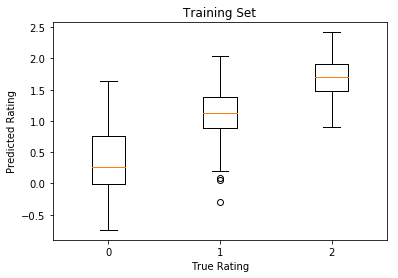

In [39]:
MakeBoxplot(Y_pred, Y, R_train, 'Training Set')

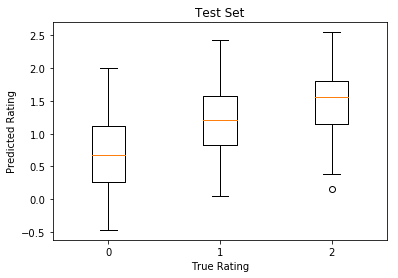

In [40]:
MakeBoxplot(Y_pred, Y, R_test, 'Test Set')

The FCP of the test set is a little better than the benchmark but worse than the collaborative filtering models (see [collaborative_filtering.ipynb](https://github.com/liyenhsu/restaurant-data-with-consumer-ratings/blob/master/collaborative_filtering.ipynb) and [gibbs_sampling.ipynb](https://github.com/liyenhsu/restaurant-data-with-consumer-ratings/blob/master/gibbs_sampling.ipynb)).